In [1]:
import numpy as np

def normalize(x):
    x = np.asarray(x, float)
    s = x.sum()
    return x / s if s > 0 else np.zeros_like(x)

# P(choice c = 1..7 | K = deviant_position), using your formulas
def likelihood_prior(alpha1_3, alpha4, alpha5, alpha6, detect4, detect5, detect6, deviant_position):
    no = (1.0 - alpha1_3)

    if deviant_position == 4:
        s = alpha1_3 + no*alpha1_3 + no**2*alpha1_3 + no**3*detect4
        out = np.array([
            alpha1_3,
            no * alpha1_3,
            no**2 * alpha1_3,
            no**3 * detect4,
            (1 - s) / 3,
            (1 - s) / 3,
            (1 - s) / 3
        ], dtype=float)
        return normalize(out)

    if deviant_position == 5:
        s = (alpha1_3
             + no*alpha1_3
             + no**2*alpha1_3
             + no**3*alpha4
             + no**3*(1 - alpha4)*detect5)
        out = np.array([
            alpha1_3,
            no * alpha1_3,
            no**2 * alpha1_3,
            no**3 * alpha4,
            no**3 * (1 - alpha4) * detect5,
            (1 - s) / 2,
            (1 - s) / 2
        ], dtype=float)
        return normalize(out)

    if deviant_position == 6:
        s = (alpha1_3
             + no*alpha1_3
             + no**2*alpha1_3
             + no**3*alpha4
             + no**3*(1 - alpha4)*alpha5
             + no**3*(1 - alpha4)*(1 - alpha5)*detect6)
        out = np.array([
            alpha1_3,
            no * alpha1_3,
            no**2 * alpha1_3,
            no**3 * alpha4,
            no**3 * (1 - alpha4) * alpha5,
            no**3 * (1 - alpha4) * (1 - alpha5) * detect6,
            (1 - s)
        ], dtype=float)
        return normalize(out)

    # deviant_position == 7 (no deviant)
    s = (alpha1_3
         + no*alpha1_3
         + no**2*alpha1_3
         + no**3*alpha4
         + no**3*(1 - alpha4)*alpha5
         + no**3*(1 - alpha4)*(1 - alpha5)*alpha6)
    out = np.array([
        alpha1_3,
        no * alpha1_3,
        no**2 * alpha1_3,
        no**3 * alpha4,
        no**3 * (1 - alpha4) * alpha5,
        no**3 * (1 - alpha4) * (1 - alpha5) * alpha6,
        (1 - s)
    ], dtype=float)
    return normalize(out)

def build_M(alpha1_3, alpha4, alpha5, alpha6, detect4, detect5, detect6):
    """
    Returns M (7x4) with columns:
    col 0 = P(choice | K=4)
    col 1 = P(choice | K=5)
    col 2 = P(choice | K=6)
    col 3 = P(choice | K=7)
    """
    cols = []
    for K in (4, 5, 6, 7):
        col = likelihood_prior(alpha1_3, alpha4, alpha5, alpha6,
                               detect4, detect5, detect6, K)
        cols.append(col.reshape(-1, 1))
    M = np.concatenate(cols, axis=1)  # shape (7,4)
    return M

# 'params': {'alpha1_3': np.float64(0.019721604437951575), 'alpha4': np.float64(0.03377930333798768), 'alpha5': np.float64(0.08457861366143432), 'alpha6': np.float64(0.061887379397915235), 'detect4': np.float64(0.9337793990713121), 'detect5': np.float64(0.9785109799997622), 'detect6': np.float64(0.9100852105245194)}}

M = build_M(0.019721604437951575, 0.03377930333798768, 0.08457861366143432, 0.061887379397915235, 0.9337793990713121, 0.9785109799997622, 0.9100852105245194)

print(M)

pbounds = {
    'alpha': (0.00001, 0.1),
    'decay': (0.000001, 0.1),
    'alpha1_3': (0.001, 0.1),
    'alpha4': (0.001, 0.1),
    'alpha5': (0.001, 0.1),
    'alpha6': (0.001, 0.1),
    'detect4': (0.5, 0.99),
    'detect5': (0.5, 0.99),
    'detect6': (0.5, 0.99)
}

[[0.0197216  0.0197216  0.0197216  0.0197216 ]
 [0.01933266 0.01933266 0.01933266 0.01933266]
 [0.01895139 0.01895139 0.01895139 0.01895139]
 [0.87961491 0.03181991 0.03181991 0.03181991]
 [0.02079314 0.89061567 0.07698129 0.07698129]
 [0.02079314 0.00977938 0.75827675 0.05156414]
 [0.02079314 0.00977938 0.07491639 0.781629  ]]


# FA/Hit rates

In [ ]:
safasdfafdsfasfsafasfasf

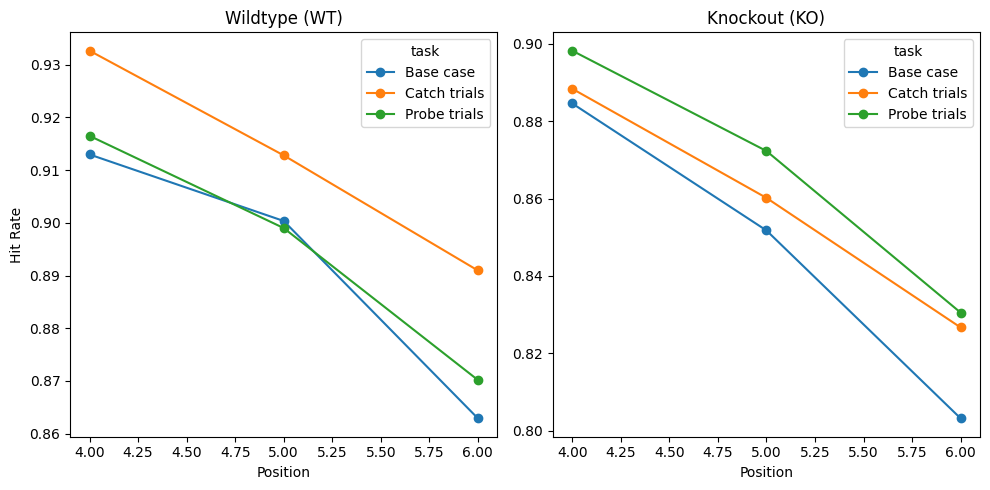

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- filtering stays the same ----
days = pd.read_csv('Oddball_data_exported_20251013.csv')
trials = pd.read_csv('Oddball_data_exported_trials_20251013.csv')
days_trials = pd.merge(trials, days, on="UUID", how="left")

days_trials = days_trials[['Trial_type', 'Genotype', 'Stim_ID', 'Response', 'task']]
days_trials = days_trials.query(
    "Trial_type == 5 and Genotype in ['Fmr1-LE_WT', 'Fmr1-LE_KO']"
)

trial_types = ['Base case', 'Catch trials', 'Probe trials']
days_trials = days_trials[days_trials['task'].isin(trial_types)]

# ---- 1. make binary hit column ----
days_trials['is_hit'] = (days_trials['Response'] == 'Hit').astype(int)

# ---- 2. compute hit rate per task × genotype × position ----
hit_rates = (
    days_trials
    .groupby(['Genotype', 'task', 'Stim_ID'])['is_hit']
    .mean()
    .reset_index()
)

# ---- 3. pivot so Stim_ID becomes x-axis ----
plot_data = hit_rates.pivot_table(
    index='Stim_ID',
    columns=['task', 'Genotype'],
    values='is_hit'
)

# ---- 4. plotting ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# WT only
plot_data.xs('Fmr1-LE_WT', level='Genotype', axis=1).plot(
    ax=ax1, marker='o'
)
ax1.set_title('Wildtype (WT)')
ax1.set_ylabel('Hit Rate')
ax1.set_xlabel('Position')

# KO only
plot_data.xs('Fmr1-LE_KO', level='Genotype', axis=1).plot(
    ax=ax2, marker='o'
)
ax2.set_title('Knockout (KO)')
ax2.set_xlabel('Position')

plt.tight_layout()
plt.show()


In [2]:
# Do it on a per rat basis

# Need to separate based on position
# alpha1_3, alpha4, alpha5, alpha6
# 

# 
# detect4, detect5, detect6 for each position

# FA positions 1 through 3, 

# How to calculate FA, FC trial and for a true Stim_ID but where is FA info?

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

days = pd.read_csv('Oddball_data_exported_20251013.csv')
trials = pd.read_csv('Oddball_data_exported_trials_20251013.csv')
days_trials = pd.merge(trials, days, on="UUID", how="left")
days_trials = days_trials.loc[days_trials['rat_name'] == 'Green1']

days_trials = days_trials[['Stim_ID','Trial_type', 'Response','Reaction_(s)']]
days_trials.columns = ['Position', 'Trial_type', 'Response', 'Decision']

days_trials['Trial_type'] = days_trials['Trial_type'].replace({5 : 'HM', 0 : 'FC'})

early_fa_df = np.floor(days_trials['Decision'] / 0.75) + 1

HIT = days_trials['Response'] == 'Hit'
MISS = days_trials['Response'] == 'Miss'
FA = days_trials['Response'] == 'FA'
HM = days_trials['Trial_type'] == 'HM'
FC = days_trials['Trial_type'] == 'FC'

days_trials.loc[HIT & HM , 'Decision'] = days_trials.loc[HIT & HM, 'Position']
days_trials.loc[MISS & HM, 'Decision'] = -1
days_trials.loc[FA & HM, 'Decision'] = early_fa_df[FA & HM]
days_trials.loc[HIT & FC, 'Decision'] = 7
days_trials.loc[FA & FC, 'Decision'] = early_fa_df[FA & FC]

days_trials['Decision'] = days_trials['Decision'].astype(int)

days_trials['FA_rate'] = (days_trials['Response'] == 'FA').astype(int)
days_trials['Hit_rate'] = (days_trials['Response'] == 'Hit').astype(int)


series = (days_trials.groupby(['Decision', 'Position'])[['FA_rate', 'Hit_rate']].sum().reset_index()).astype(int)
FA_df = series.pivot_table(index = 'Decision', columns='Position', values='FA_rate')
Hit_df = series.pivot_table(index = 'Decision', columns='Position', values='Hit_rate')

response_df = days_trials.groupby(['Position'])['Response'].count()

FA_df = FA_df / response_df
Hit_df = Hit_df / response_df

FA_df = FA_df.replace(float(0), pd.NA)
Hit_df = Hit_df.replace(float(0), pd.NA)

FA_df = FA_df.drop([-1, 7, 8]).apply(pd.to_numeric, errors='coerce')
Hit_df = Hit_df.drop([-1, 7, 8]).apply(pd.to_numeric, errors='coerce')

FA_rate = FA_df.mean(axis=1, numeric_only=True)

alpha1_3 = FA_rate[1:3].mean()
alpha4 = FA_rate[4]
alpha5 = FA_rate[5]
alpha6 = FA_rate[6]

detect4 = Hit_df.at[4, 4]
detect5 = Hit_df.at[5, 5]
detect6 = Hit_df.at[6, 6]

print(Hit_df)
print(FA_rate)


Position         4         5        6   7
Decision                                 
1              NaN       NaN      NaN NaN
2              NaN       NaN      NaN NaN
3              NaN       NaN      NaN NaN
4         0.902587       NaN      NaN NaN
5              NaN  0.871938      NaN NaN
6              NaN       NaN  0.82879 NaN
Decision
1    0.026277
2    0.020216
3    0.029566
4    0.043648
5    0.056903
6    0.074248
dtype: float64


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

N = 50  # number of trials

mock_df = pd.DataFrame({
    'Genotype': np.random.choice(['Fmr1-LE_WT', 'Fmr1-LE_KO'], size=N),
    'task': np.random.choice(['Base case', 'Catch trials', 'Probe trials'], size=N),
    'Stim_ID': np.random.choice([4, 5, 6], size=N),
    'Response': np.random.choice(['Hit', 'Miss', 'FA'], size=N)
})

print(mock_df.loc[mock_df['Genotype'] == 'Fmr1-LE_WT', :])

print(mock_df.head())
print(mock_df.shape)


      Genotype          task  Stim_ID Response
0   Fmr1-LE_WT     Base case        5       FA
3   Fmr1-LE_WT  Catch trials        4      Hit
11  Fmr1-LE_WT     Base case        5       FA
12  Fmr1-LE_WT     Base case        6       FA
14  Fmr1-LE_WT  Catch trials        6      Hit
15  Fmr1-LE_WT  Catch trials        4      Hit
16  Fmr1-LE_WT  Probe trials        5      Hit
17  Fmr1-LE_WT     Base case        6      Hit
18  Fmr1-LE_WT     Base case        6       FA
20  Fmr1-LE_WT     Base case        4      Hit
23  Fmr1-LE_WT  Probe trials        4     Miss
24  Fmr1-LE_WT     Base case        6       FA
29  Fmr1-LE_WT  Probe trials        6       FA
31  Fmr1-LE_WT  Probe trials        6     Miss
33  Fmr1-LE_WT  Probe trials        6      Hit
36  Fmr1-LE_WT  Catch trials        6     Miss
39  Fmr1-LE_WT     Base case        6     Miss
40  Fmr1-LE_WT  Probe trials        5      Hit
42  Fmr1-LE_WT     Base case        6     Miss
48  Fmr1-LE_WT     Base case        6      Hit
     Genotype

In [ ]:
import pandas as pd
import numpy as np

days = pd.read_csv('Oddball_data_exported_20251013.csv')
trials = pd.read_csv('Oddball_data_exported_trials_20251013.csv')
days_trials = pd.merge(trials, days, on="UUID", how="left")

days_trials = days_trials.loc[days_trials['genotype'] == 'WT']

days_trials = days_trials.loc[days_trials['task'] == 'Catch trials']

print(days_trials['rat_name'].unique())

['Blue1' 'Blue2' 'Blue3' 'Blue4' 'RP4' 'GP4' 'LP3' 'Green4' 'Purple1'
 'Purple2']


In [1]:
import pandas as pd
import numpy as np

days = pd.read_csv('Oddball_data_exported_20251013.csv')
trials = pd.read_csv('Oddball_data_exported_trials_20251013.csv')
days_trials = pd.merge(trials, days, on="UUID", how="left")

days_trials = days_trials.loc[days_trials['genotype'] == 'KO']

days_trials = days_trials.loc[days_trials['task'] == 'Catch trials']

print(days_trials['rat_name'].unique())

['LP1' 'LP4' 'Green3' 'Green1']
